
# **The dataset contains 36733 instances of 11 sensor measures aggregated over one hour (by means of average or sum) from a gas turbine.**
# **The Dataset includes gas turbine parameters (such as Turbine Inlet Temperature and Compressor Discharge pressure) in addition to the ambient variables.**
# **Problem statement: predicting turbine energy yield (TEY) using ambient variables as features.**



In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
tf.debugging.set_log_device_placement(False)
import warnings
warnings.filterwarnings("ignore")

In [37]:
# Generating reproducible results from same code
tf.random.set_seed(14)

In [38]:
from google.colab import files
uploaded = files.upload()

Saving gas_turbines.csv to gas_turbines (1).csv


In [39]:
gas = pd.read_csv("gas_turbines.csv")
gas

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311
...,...,...,...,...,...,...,...,...,...,...,...
15034,9.0301,1005.6,98.460,3.5421,19.164,1049.7,546.21,111.61,10.400,4.5186,79.559
15035,7.8879,1005.9,99.093,3.5059,19.414,1046.3,543.22,111.78,10.433,4.8470,79.917
15036,7.2647,1006.3,99.496,3.4770,19.530,1037.7,537.32,110.19,10.483,7.9632,90.912
15037,7.0060,1006.8,99.008,3.4486,19.377,1043.2,541.24,110.74,10.533,6.2494,93.227


In [40]:
gas.isna().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

In [41]:
gas.duplicated().sum()

0

In [42]:
df = gas[["AT", "AP", "AH", "TEY"]]
df.head()

,AT,AP,AH,TEY
0,6.8594,1007.9,96.799,114.70
1,6.7850,1008.4,97.118,114.72
2,6.8977,1008.8,95.939,114.71
3,7.0569,1009.2,95.249,114.72
4,7.3978,1009.7,95.150,114.72


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   TEY     15039 non-null  float64
dtypes: float64(4)
memory usage: 470.1 KB


In [44]:
df.describe()

,AT,AP,AH,TEY
count,15039.000000,15039.00000,15039.000000,15039.000000
mean,17.764381,1013.19924,79.124174,134.188464
std,7.574323,6.41076,13.793439,15.829717
min,0.522300,985.85000,30.344000,100.170000
25%,11.408000,1008.90000,69.750000,127.985000
50%,18.186000,1012.80000,82.266000,133.780000
75%,23.862500,1016.90000,90.043500,140.895000
max,34.929000,1034.20000,100.200000,174.610000


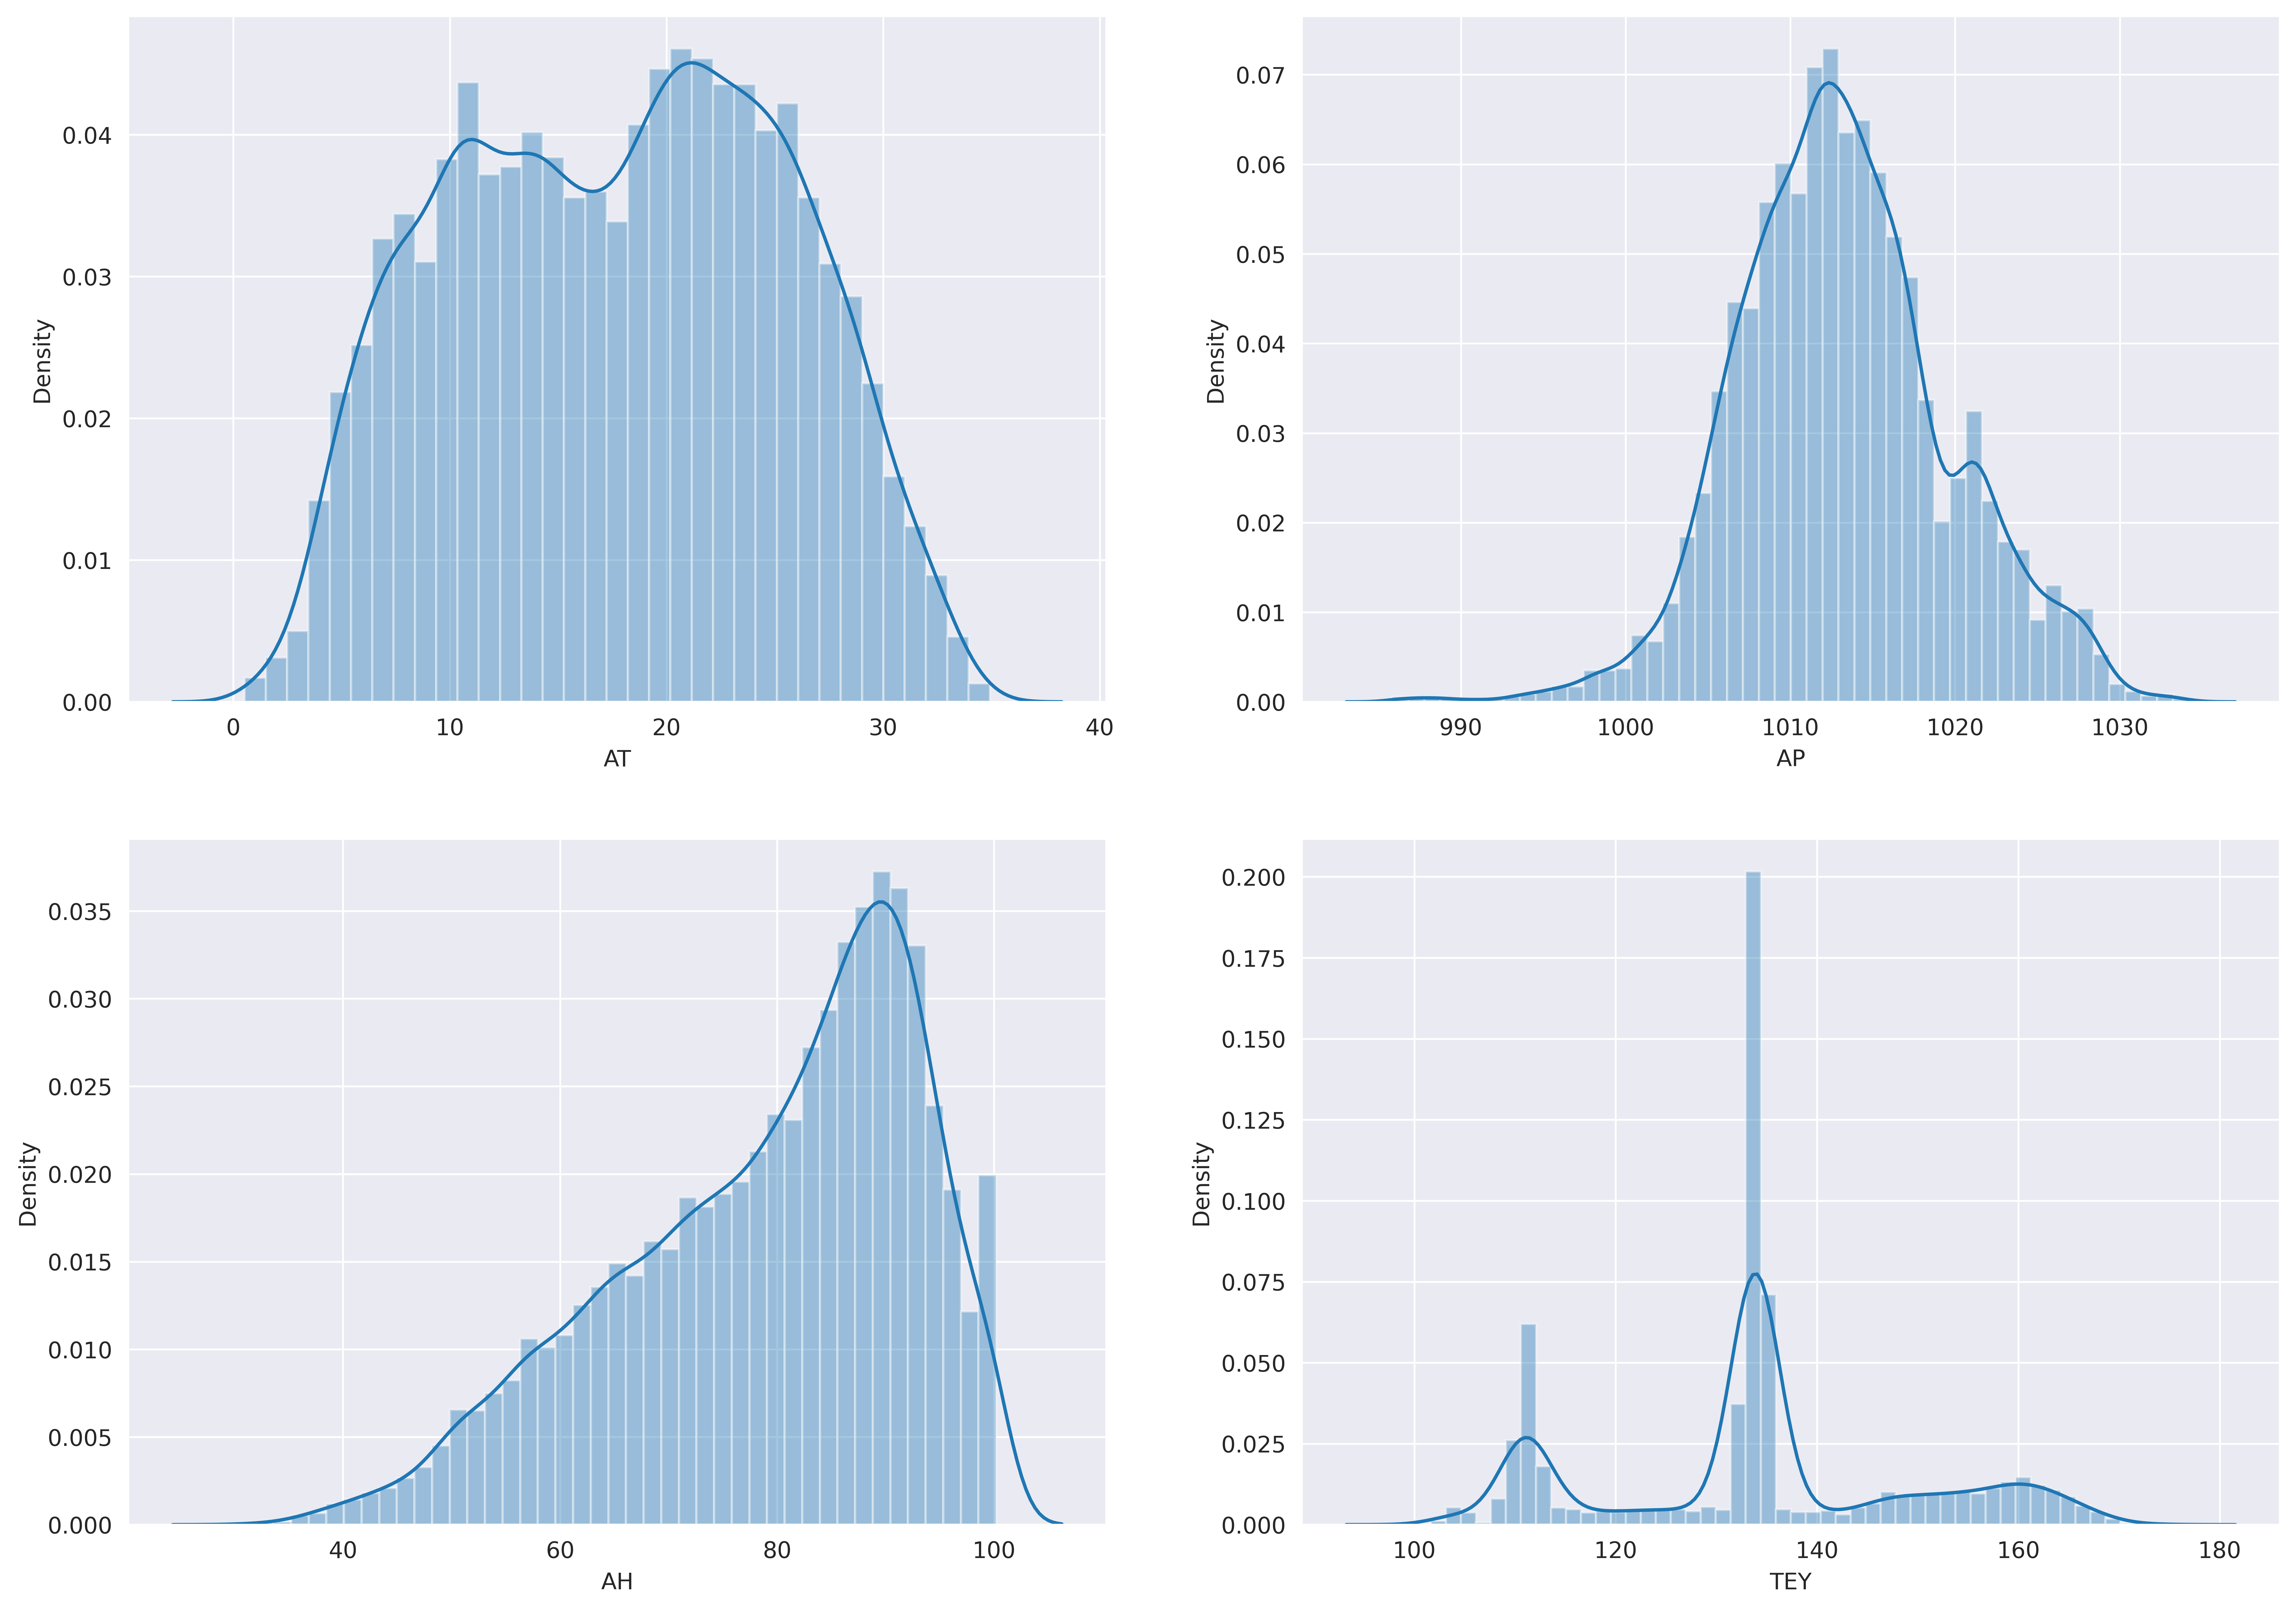

In [45]:
# distplot

fig, ax = plt.subplots(2,2, figsize = (17,12), dpi = 600)

sns.distplot(df.AT, ax = ax[0,0])
sns.distplot(df.AP, ax = ax[0,1])
sns.distplot(df.AH, ax = ax[1,0])
sns.distplot(df.TEY, ax = ax[1,1])
plt.show()

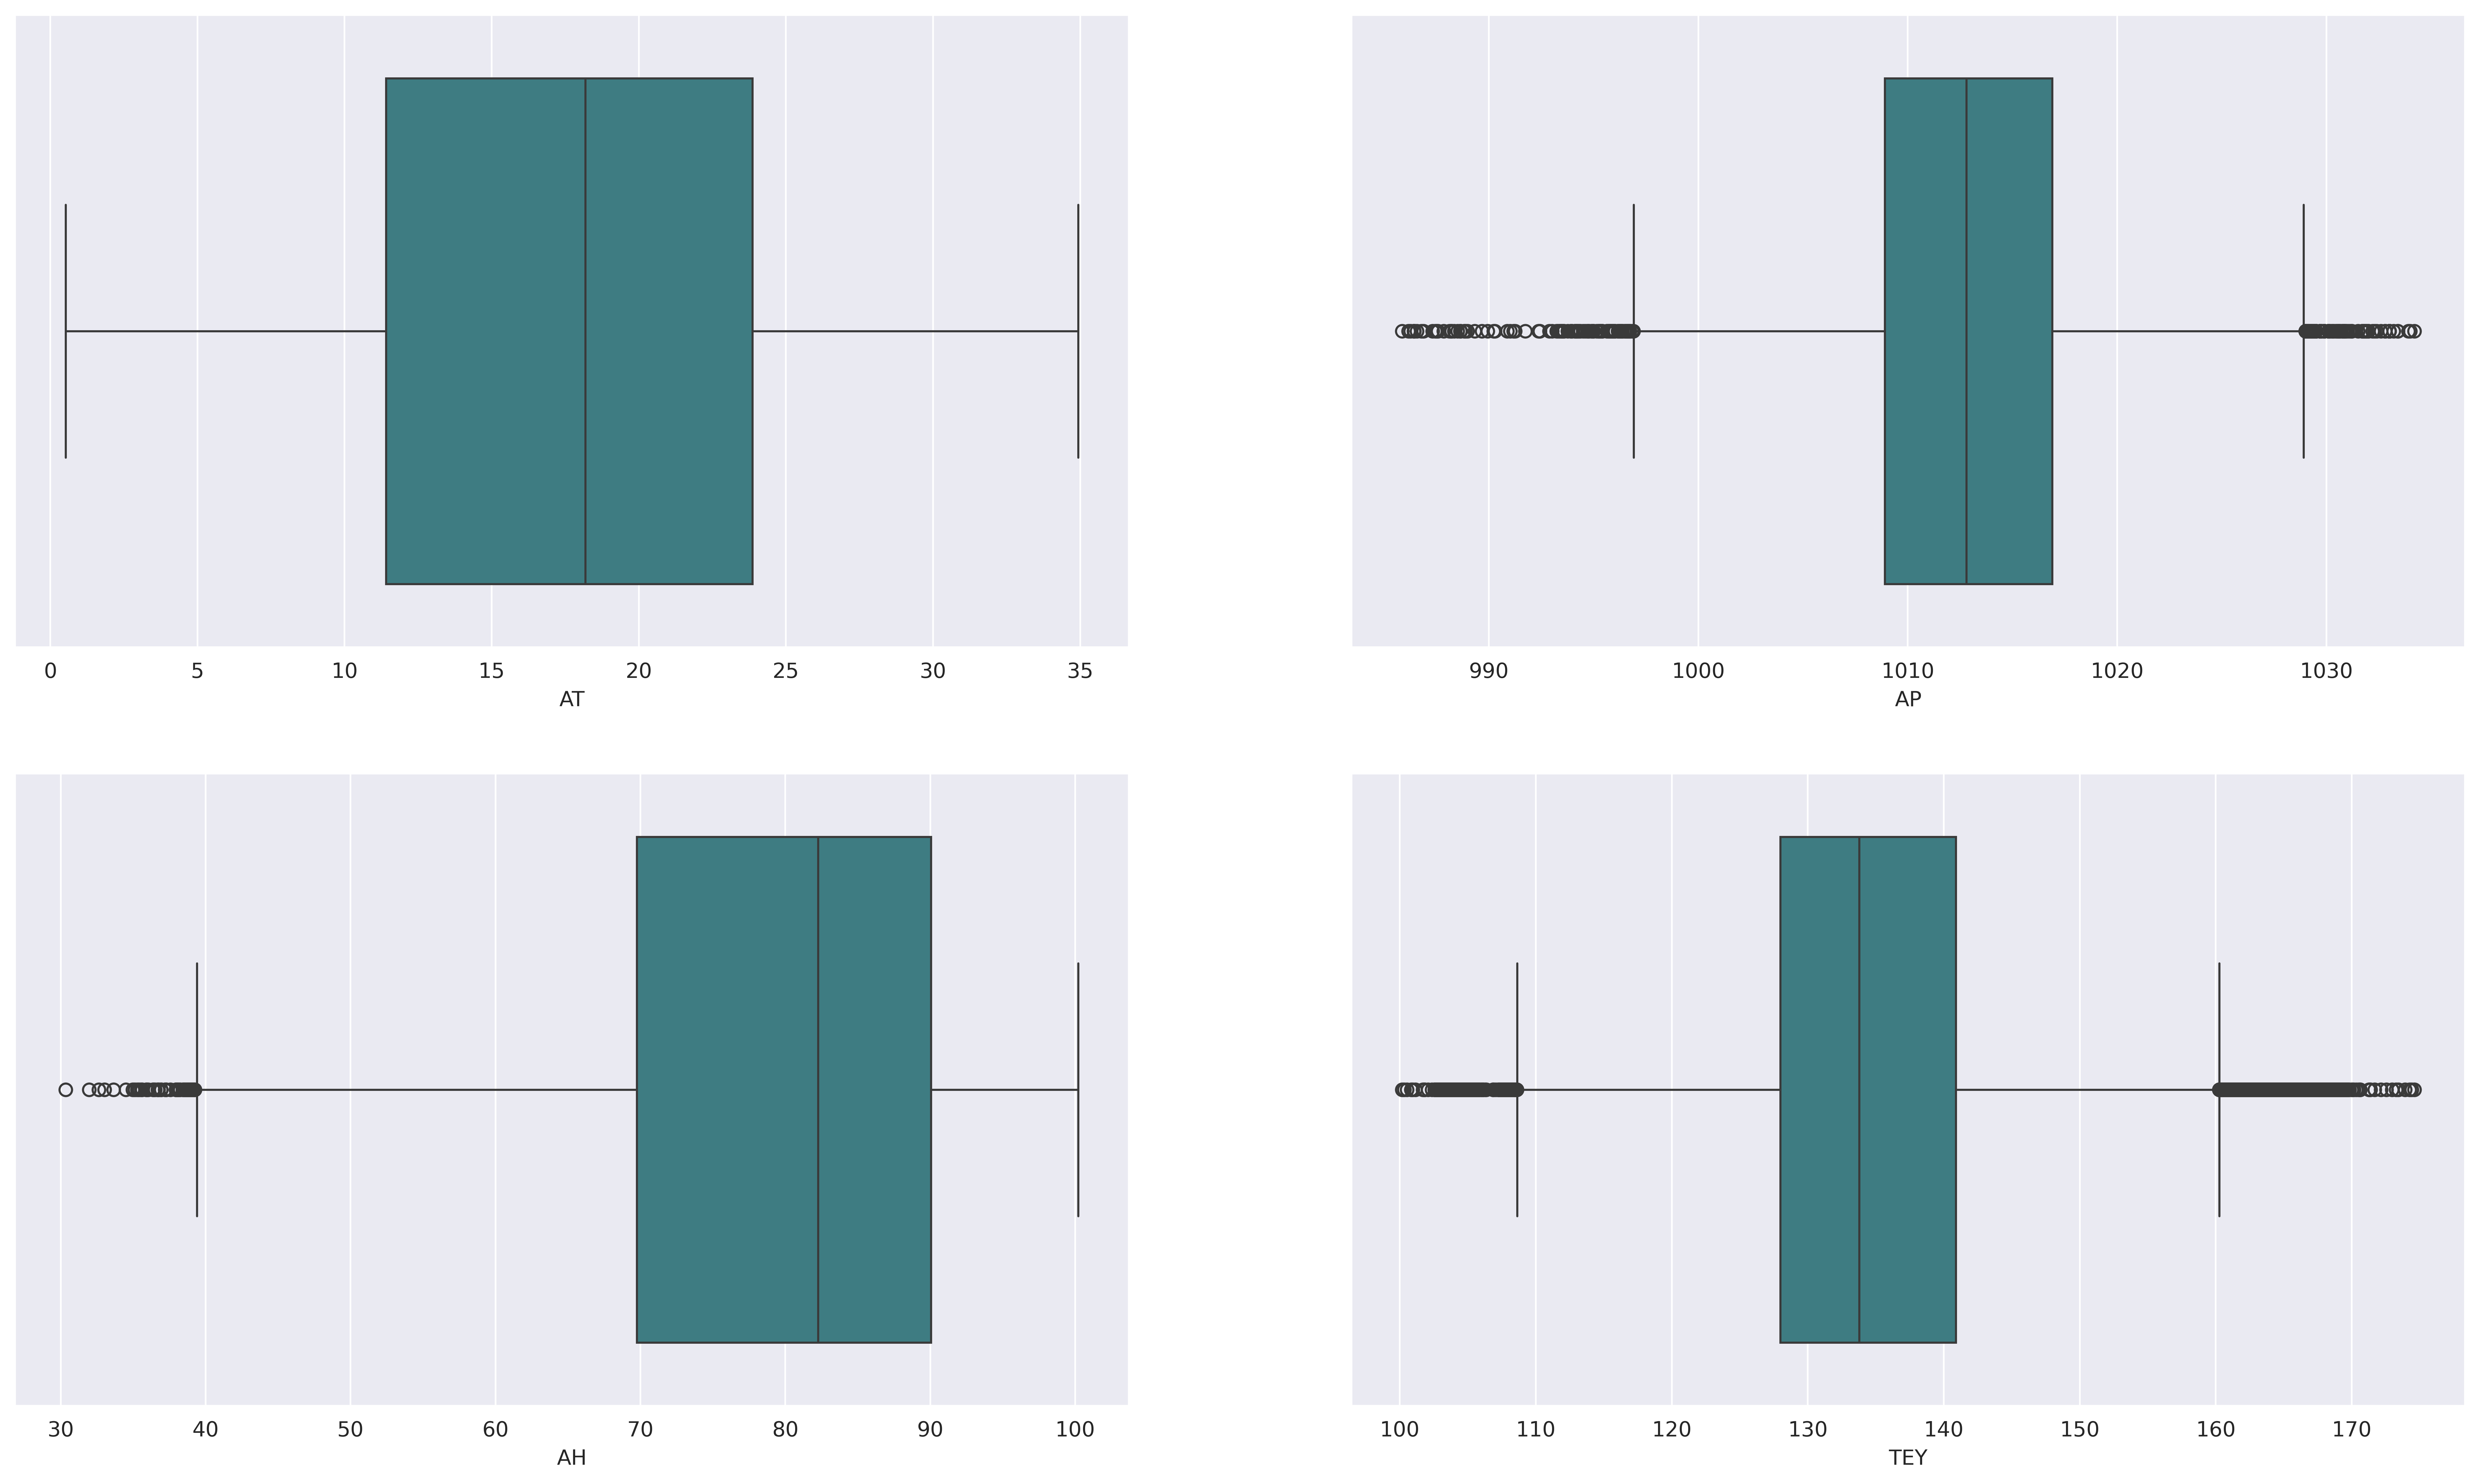

In [46]:
# Outlier detection
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (21, 12), dpi = 500)
sns.boxplot(x = "AT", data = df, palette = "crest", ax = axes[0,0])
sns.boxplot(x = "AP", data = df, palette = "crest", ax = axes[0,1])
sns.boxplot(x = "AH", data = df, palette = "crest", ax = axes[1,0])
sns.boxplot(x = "TEY", data = df, palette = "crest", ax = axes[1,1])
plt.show()

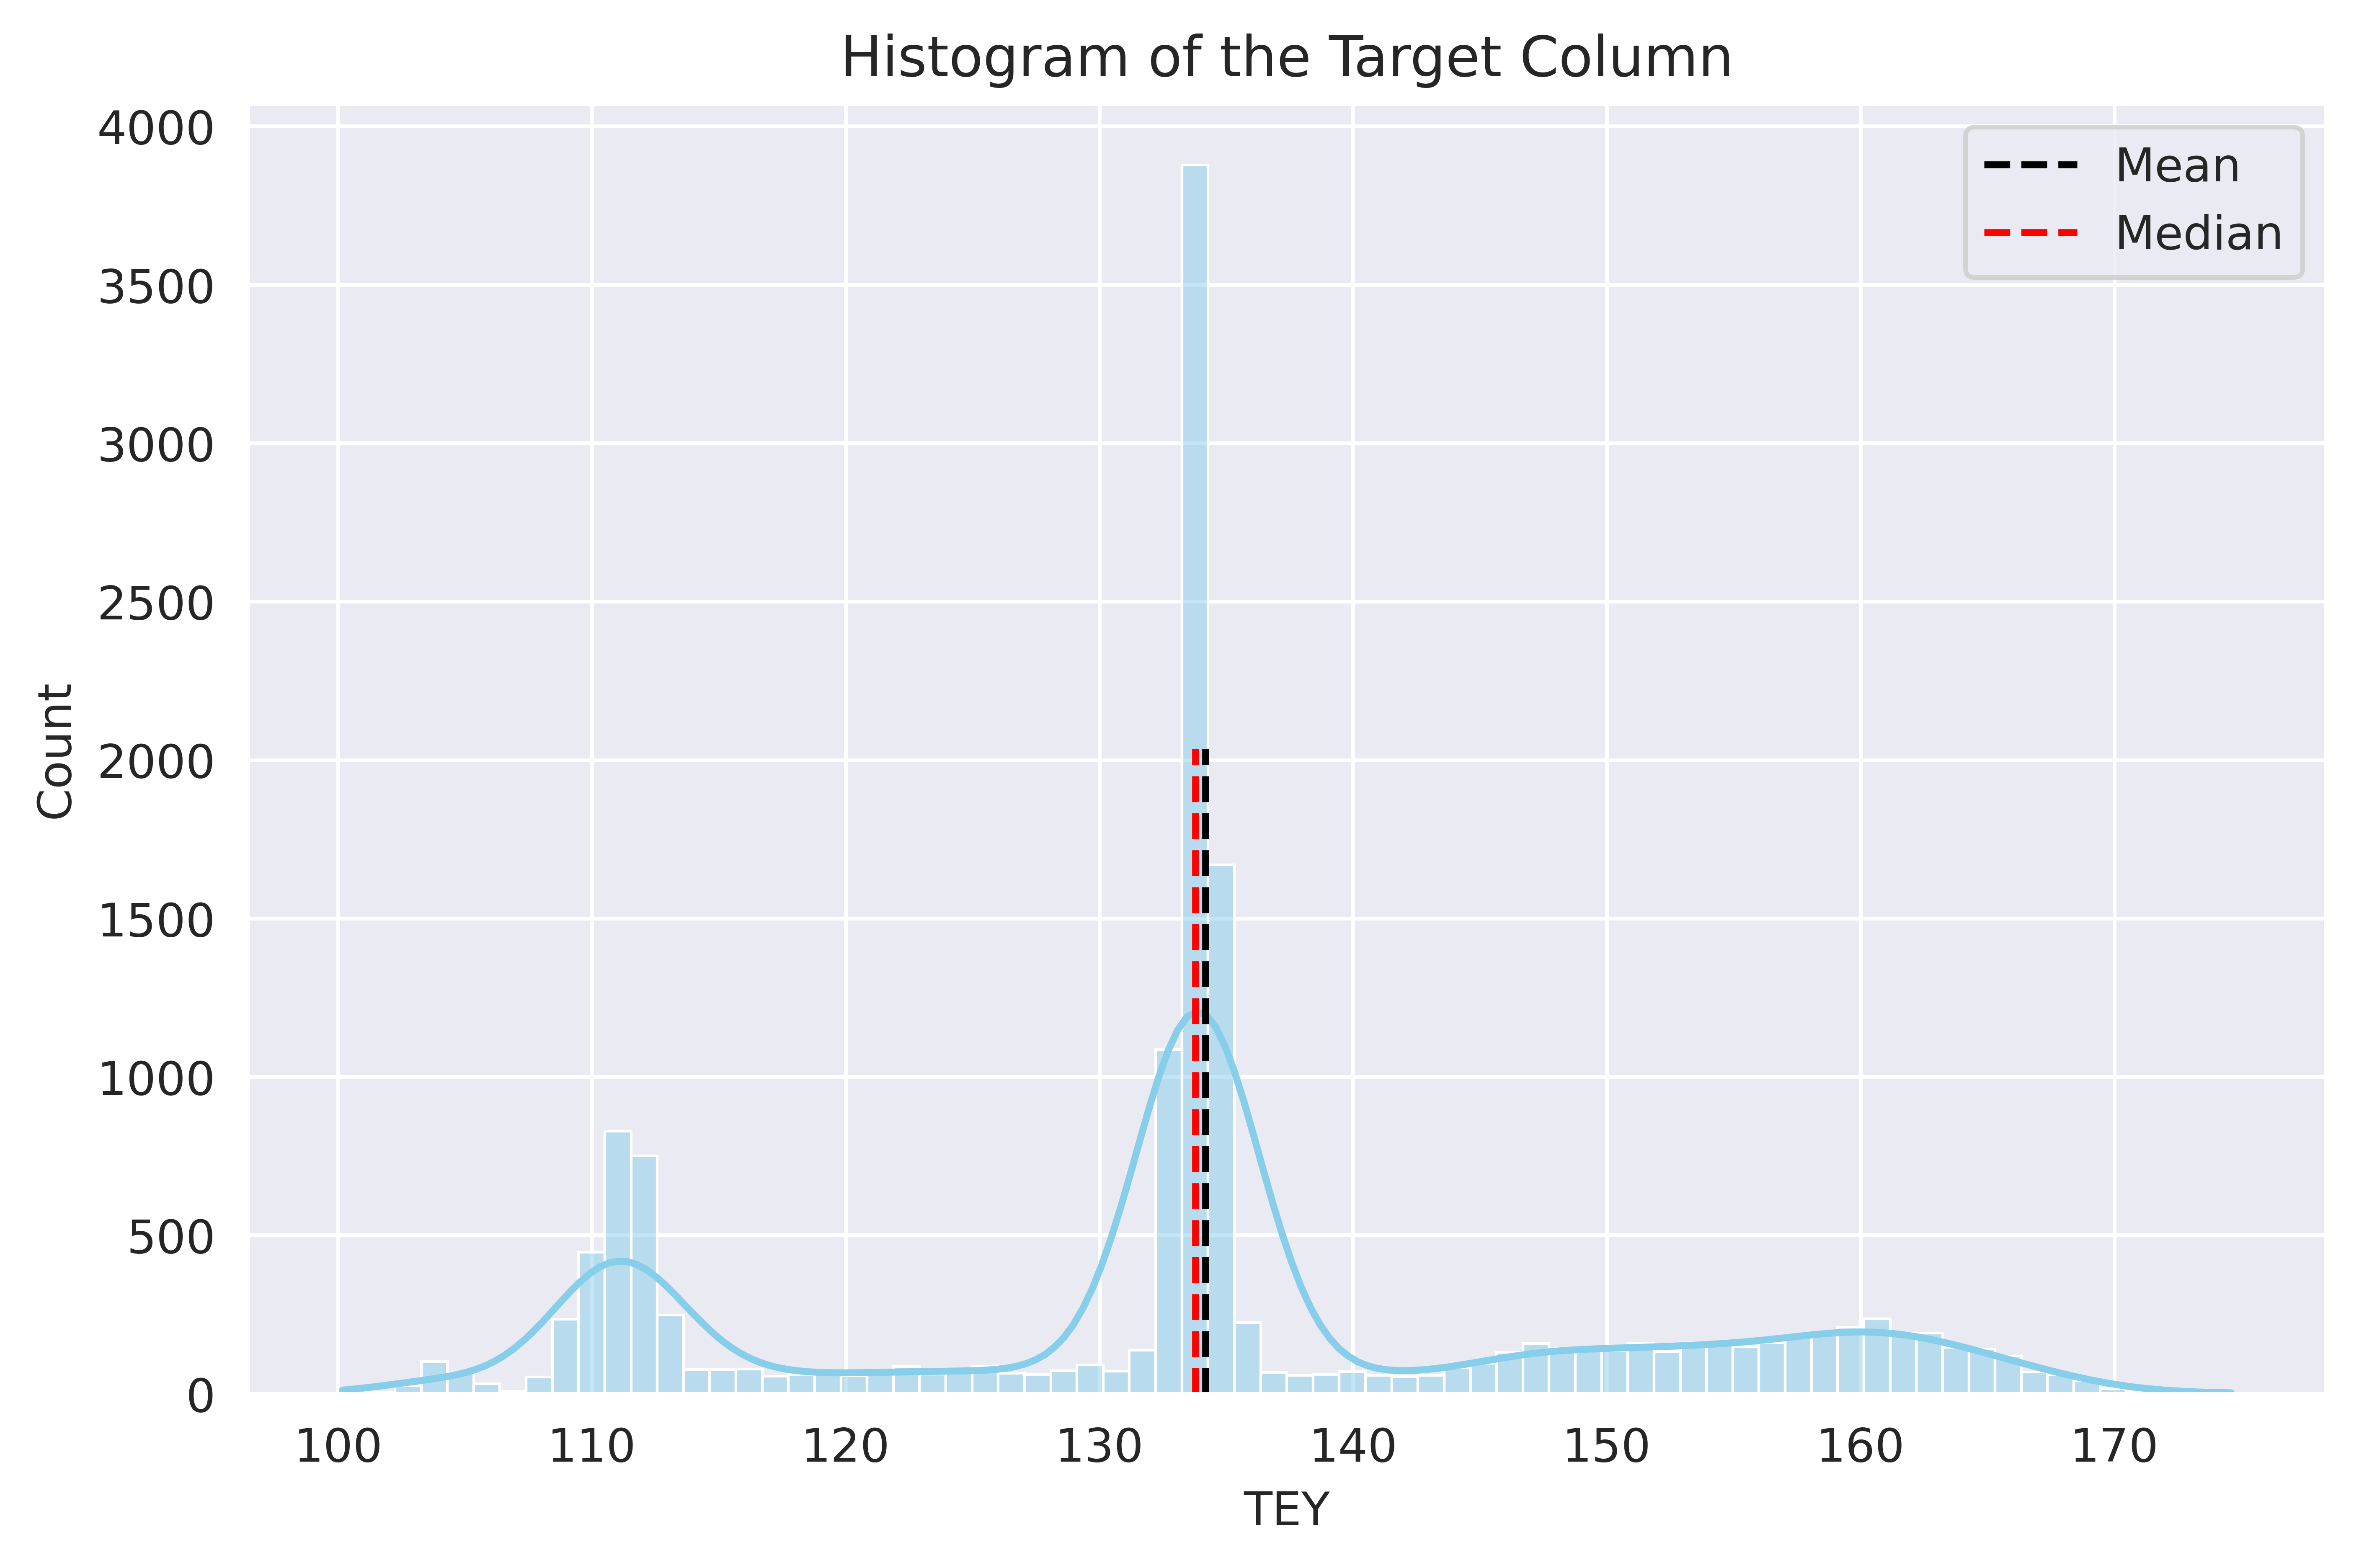

In [47]:
sns.set_style("darkgrid")
plt.figure(figsize = (8,5), dpi = 800)
sns.histplot(data = df, x = "TEY", color = "skyblue", kde = True)
plt.axvline(x = df["TEY"].mean(), ymax = 0.5, color = "black", linestyle = "--", label = "Mean")
plt.axvline(x = df["TEY"].median(), ymax = 0.5, color = "red", linestyle = "--", label = "Median")
plt.legend()
plt.title("Histogram of the Target Column")
plt.show()

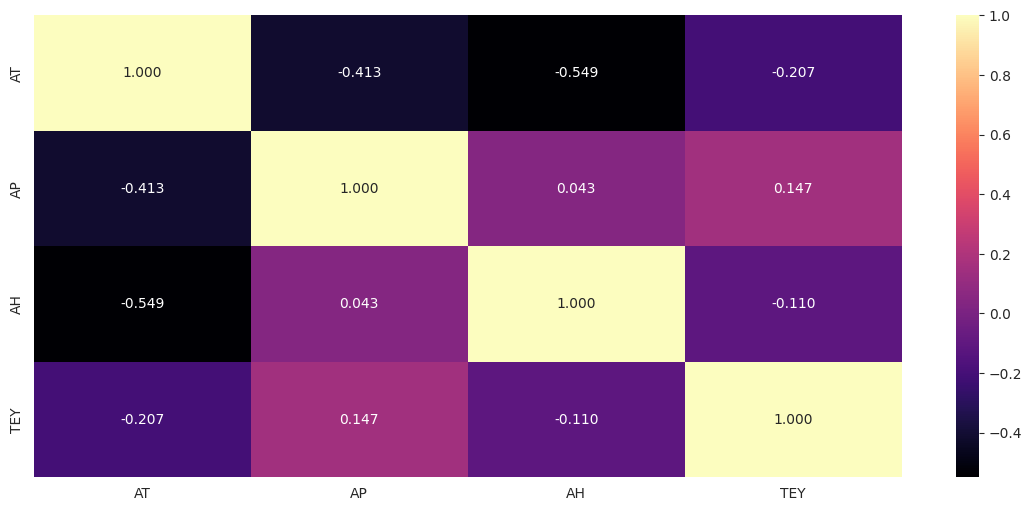

In [48]:
# Heatmap
plt.figure(figsize = (14, 6));
sns.heatmap(df.corr(), cmap = "magma", annot = True, fmt = ".3f")
plt.show()

# **Feature Analysis**

In [49]:
from numpy import set_printoptions
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest

In [50]:
# Splitting the data into train and test
X = df.iloc[:,:-1]
Y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3)

In [51]:
y_train = np.reshape(y_train.to_numpy(), (-1,1))
y_test = np.reshape(y_test.to_numpy(), (-1,1))

In [52]:
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_x.fit(X_train)
xtrain_scale = scaler_x.transform(X_train)

scaler_x.fit(X_test)
xtest_scale = scaler_x.transform(X_test)

scaler_y.fit(y_train)
ytrain_scale = scaler_y.transform(y_train)

scaler_y.fit(y_test)
ytest_scale = scaler_y.transform(y_test)

In [53]:
len(xtrain_scale)

10527

In [54]:
test = SelectKBest(score_func = mutual_info_regression, k = "all")
fit = test.fit(X, Y)

In [55]:
scores = fit.scores_
features = fit.transform(X)

In [56]:
score_df = pd.DataFrame(list(zip(scores, X.columns)), columns = ["Score", "Feature"])
score_df.sort_values(by = "Score", ascending = False, inplace = True)
score_df

,Score,Feature
0,0.412142,AT
1,0.137523,AP
2,0.097669,AH


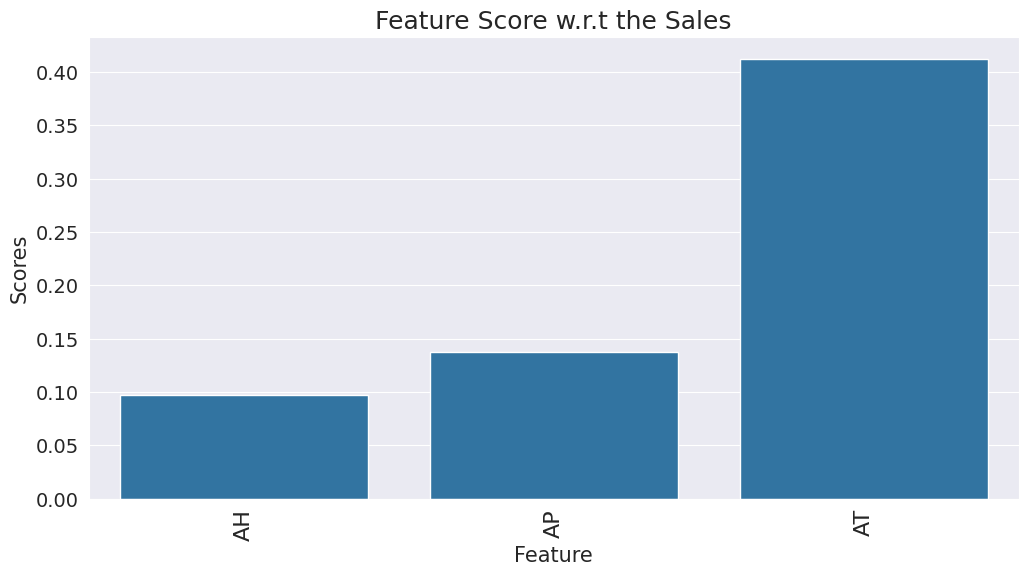

In [57]:
plt.figure(figsize = (12,6))
sns.barplot(x = "Feature", y = "Score", data = score_df, order = score_df.sort_values("Score").Feature)
plt.xlabel("Feature", size = 15)
plt.ylabel("Scores", size = 15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Score w.r.t the Sales", size = 18)
plt.show()

In [58]:
score_df.sort_values("Score", ascending = False)

,Score,Feature
0,0.412142,AT
1,0.137523,AP
2,0.097669,AH


# **Neural Network Modelling**

In [59]:
# Create model
model = Sequential()
model.add(Dense(4, input_dim = 3, kernel_initializer = "normal", activation = "relu"))
model.add(Dense(2106, kernel_initializer = "normal", activation = "relu"))
model.add(Dense(1, activation = "linear"))

# Compile model
model.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["mse", "mae"])

# Fit the model
hist = model.fit(xtrain_scale, ytrain_scale, validation_split = 0.33, epochs = 100, batch_size = 150)

Epoch 1/100
48/48 [==============================] - 1s 9ms/step - loss: 0.0752 - mse: 0.0752 - mae: 0.2126 - val_loss: 0.0464 - val_mse: 0.0464 - val_mae: 0.1551
Epoch 2/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0465 - mse: 0.0465 - mae: 0.1571 - val_loss: 0.0460 - val_mse: 0.0460 - val_mae: 0.1538
Epoch 3/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0459 - mse: 0.0459 - mae: 0.1549 - val_loss: 0.0454 - val_mse: 0.0454 - val_mae: 0.1537
Epoch 4/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0452 - mse: 0.0452 - mae: 0.1552 - val_loss: 0.0446 - val_mse: 0.0446 - val_mae: 0.1543
Epoch 5/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0443 - mse: 0.0443 - mae: 0.1562 - val_loss: 0.0437 - val_mse: 0.0437 - val_mae: 0.1569
Epoch 6/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0436 - mse: 0.0436 - mae: 0.1587 - val_loss: 0.0435 - val_mse: 0.0435 - val_mae: 0.1602
Epoch 7/100
48/48 [===

In [60]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 4)                 16        
                                                                 
 dense_12 (Dense)            (None, 2106)              10530     
                                                                 
 dense_13 (Dense)            (None, 1)                 2107      
                                                                 
Total params: 12653 (49.43 KB)
Trainable params: 12653 (49.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
# Define the first model architecture
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = "relu", input_shape = (X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "linear")])

# Compile the first model
model1.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["mae"])

# Fit the first model to the training data
model1.fit(X_train, y_train, epochs = 50, batch_size = 16, validation_data = (X_test, y_test))

Epoch 1/50
658/658 [==============================] - 4s 4ms/step - loss: 574.7053 - mae: 14.2797 - val_loss: 250.9742 - val_mae: 11.7072
Epoch 2/50
658/658 [==============================] - 2s 3ms/step - loss: 242.2313 - mae: 11.6167 - val_loss: 243.3282 - val_mae: 11.4938
Epoch 3/50
658/658 [==============================] - 2s 2ms/step - loss: 240.4933 - mae: 11.7491 - val_loss: 250.3192 - val_mae: 12.4517
Epoch 4/50
658/658 [==============================] - 2s 2ms/step - loss: 235.0142 - mae: 11.7366 - val_loss: 231.6487 - val_mae: 11.6251
Epoch 5/50
658/658 [==============================] - 2s 2ms/step - loss: 229.7811 - mae: 11.7756 - val_loss: 227.3103 - val_mae: 11.6230
Epoch 6/50
658/658 [==============================] - 2s 2ms/step - loss: 233.0188 - mae: 12.0326 - val_loss: 227.4494 - val_mae: 11.7407
Epoch 7/50
658/658 [==============================] - 2s 3ms/step - loss: 230.3021 - mae: 11.9883 - val_loss: 226.0251 - val_mae: 11.7318
Epoch 8/50
658/658 [==============

In [62]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 32)                128       
                                                                 
 dense_15 (Dense)            (None, 16)                528       
                                                                 
 dense_16 (Dense)            (None, 1)                 17        
                                                                 
Total params: 673 (2.63 KB)
Trainable params: 673 (2.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
# Define the second model architecture
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation = "relu", input_shape = (X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(16, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "linear")])

# Compile the second model
model2.compile(optimizer = "adam", loss = "mean_absolute_error", metrics = ["mse"])

# Fit the second model to the training data
model2.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/100
329/329 [==============================] - 4s 6ms/step - loss: 12.2764 - mse: 272.3830 - val_loss: 11.3116 - val_mse: 254.1864
Epoch 2/100
329/329 [==============================] - 2s 6ms/step - loss: 11.5297 - mse: 249.5889 - val_loss: 11.7334 - val_mse: 254.1757
Epoch 3/100
329/329 [==============================] - 1s 3ms/step - loss: 11.4877 - mse: 246.0528 - val_loss: 11.2707 - val_mse: 246.6171
Epoch 4/100
329/329 [==============================] - 1s 3ms/step - loss: 11.6070 - mse: 245.6870 - val_loss: 11.2502 - val_mse: 244.3555
Epoch 5/100
329/329 [==============================] - 1s 3ms/step - loss: 11.4631 - mse: 242.3102 - val_loss: 11.2730 - val_mse: 243.4417
Epoch 6/100
329/329 [==============================] - 1s 3ms/step - loss: 11.5310 - mse: 243.0405 - val_loss: 11.9719 - val_mse: 252.1634
Epoch 7/100
329/329 [==============================] - 1s 2ms/step - loss: 11.4396 - mse: 240.8471 - val_loss: 11.3409 - val_mse: 243.9320
Epoch 8/100
329/329 [======

In [64]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 64)                256       
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 16)                528       
                                                                 
 dense_20 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2881 (11.25 KB)
Trainable params: 2881 (11.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **Model Evaluation**

In [65]:
y_predict = model.predict(xtest_scale)

141/141 [==============================] - 1s 2ms/step


In [66]:
y_pred1 = model1.predict(xtest_scale)

141/141 [==============================] - 1s 3ms/step


In [67]:
y_pred2 = model2.predict(xtest_scale)

141/141 [==============================] - 0s 2ms/step


In [68]:
print(hist.history.keys())

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


In [72]:
hist_df = pd.DataFrame(hist.history)
hist_df["epoch"] = hist.epoch
hist_df.tail()

,loss,mse,mae,val_loss,val_mse,val_mae,epoch
95,0.038778,0.038778,0.155324,0.038310,0.038310,0.152511,95
96,0.038643,0.038643,0.155338,0.038576,0.038576,0.152369,96
97,0.038915,0.038915,0.155356,0.038685,0.038685,0.154068,97
98,0.038733,0.038733,0.155542,0.038232,0.038232,0.152886,98
99,0.038631,0.038631,0.154308,0.040082,0.040082,0.158214,99


# **Visualizing**

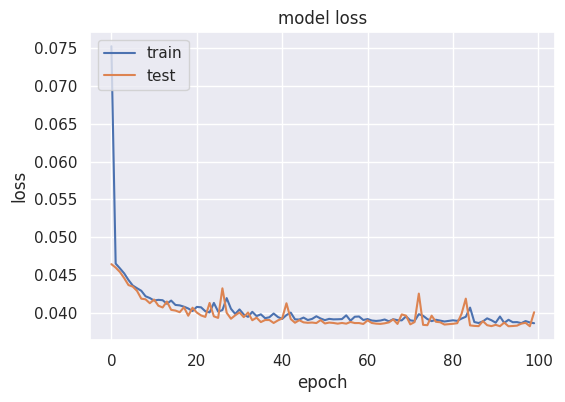

In [71]:
# summarize history for loss

sns.set(rc = {"figure.figsize":(6,4)})

plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc = "upper left")
plt.show()

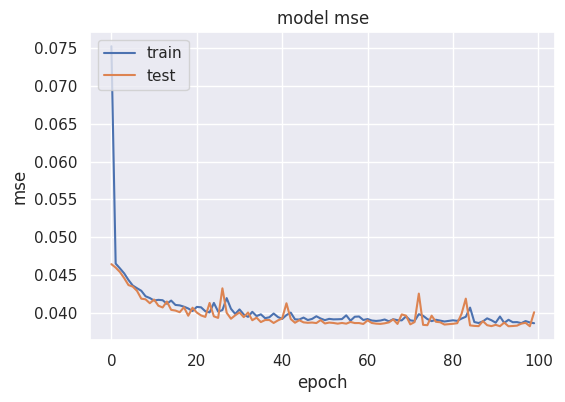

In [73]:
# Summarize History For Loss

plt.plot(hist.history["mse"])
plt.plot(hist.history["val_mse"])
plt.title("model mse")
plt.ylabel("mse")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc = "upper left")
plt.show()